### Analysis of CHIRPS-GEFS forecasts and observed dry spells
Goal is to see if CHIRPS-GEFS provides a signal for the occurence of a dry spell in the coming 15 days   
We do this by looking at historical CHIRPS-GEFS data, and classifying the occurence of a dry spell according to this forecast per admin 2   
This information is thereafter coupled to historically observed dry spells   

From the first analysis we find that there is not much correlation between forecasted and observed dry spells. However, we need to further understand if the analysis was computed correclty, and if so, what the cause of these differences is. 


Questions
- Defined a dry spell being forecasted if cell with the maximum value that touches the admin2 is forecasted to receive maximum 2mm of rain. Is this a good definition?
- Is it logical to look at the correlation of a dry spell starting at the first date of the forecast, or should we look more broadly at the occurence of a dry spell during the forecast period?
- Any other methodologies to combine binary geospatial timeseries?
- [Given deadline, lets wait but important for future] The size of the CHIRPS-GEFS data is now 23.4GB... Could we do something to make that smaller/not have to save it locally?      
    Climateserv might be an option, includes chirps-gefs data and can select per country and has an API. However, not clear what exactly the data is that you can download (how many days forecast) and API is hard to understand, and not sure if includes latest data. Someone using the API [here](https://github.com/Servir-Mekong/ClimateSERV_CHIRPS-GEFS/blob/master/Get_CHIRPS_GEFSv1/bin/ClimateServ_CHIPS-GEFS.py)

To do:
- Understand why observed and forecasted dry spells don't match
- Get a bit better understanding of the CHIRPS-GEFS methodology
- Make sure the date of the filename is the first date of the forecast

### set general variables and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import datetime
from datetime import timedelta
import re
import seaborn as sns

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[0]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

#### Set config values

In [9]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [10]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Rainy season
Compute a datetimeindex with all dates across all rainy seasons

In [11]:
#path to data start and end rainy season
df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail.csv"))
df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])

In [12]:
df_rain

,ID,pcode,ADM2_EN,season_approx,onset_date,onset_month,cessation_date,cessation_month,rainy_season_duration,rainy_season_rainfall
0,6.0,MW101,Chitipa,2009,NaT,NaN,2010-05-22,5.0,NaN,NaN
1,6.0,MW101,Chitipa,2010,2010-11-23,11.0,2011-06-03,6.0,193.0,3166.9
2,6.0,MW101,Chitipa,2011,2011-11-07,11.0,2012-05-27,5.0,203.0,2684.5
3,6.0,MW101,Chitipa,2012,2012-11-01,11.0,2013-06-09,6.0,221.0,3485.9
4,6.0,MW101,Chitipa,2013,2013-11-24,11.0,2014-06-02,6.0,191.0,3639.0
...,...,...,...,...,...,...,...,...,...,...
379,3.0,MW315,Blantyre City,2016,2016-11-20,11.0,2017-03-18,3.0,119.0,1144.6
380,3.0,MW315,Blantyre City,2017,2017-11-11,11.0,2018-03-17,3.0,127.0,902.8
381,3.0,MW315,Blantyre City,2018,2018-11-23,11.0,2019-04-03,4.0,132.0,1303.2
382,3.0,MW315,Blantyre City,2019,2019-11-23,11.0,2020-03-15,3.0,114.0,907.5


In [13]:
#get min onset and max cessation for each season across all admin2's
df_rain_seas=df_rain.groupby("season_approx",as_index=False).agg({'onset_date': np.min,"cessation_date":np.max})

In [14]:
df_rain_seas

,season_approx,onset_date,cessation_date
0,2009,NaT,2010-06-15
1,2010,2010-11-01,2011-06-06
2,2011,2011-11-02,2012-06-14
3,2012,2012-11-01,2013-06-14
4,2013,2013-11-01,2014-06-11
5,2014,2014-11-09,2015-06-15
6,2015,2015-11-01,2016-06-13
7,2016,2016-11-01,2017-06-28
8,2017,2017-11-01,2018-06-10
9,2018,2018-11-01,2019-06-13


In [15]:
#set the onset and cessation date for the seasons with them missing (meaning there was no dry spell data from start/till end of the season)
df_rain_seas[df_rain_seas.onset_date.isnull()]=df_rain_seas[df_rain_seas.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
df_rain_seas[df_rain_seas.cessation_date.isnull()]=df_rain_seas[df_rain_seas.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))

In [16]:
df_rain_seas

,season_approx,onset_date,cessation_date
0,2009,2009-11-01,2010-06-15
1,2010,2010-11-01,2011-06-06
2,2011,2011-11-02,2012-06-14
3,2012,2012-11-01,2013-06-14
4,2013,2013-11-01,2014-06-11
5,2014,2014-11-09,2015-06-15
6,2015,2015-11-01,2016-06-13
7,2016,2016-11-01,2017-06-28
8,2017,2017-11-01,2018-06-10
9,2018,2018-11-01,2019-06-13


In [17]:
all_dates=pd.Index([])
for i in df_rain_seas.season_approx.unique():
    seas_range=pd.date_range(df_rain_seas[df_rain_seas.season_approx==i].onset_date.values[0],df_rain_seas[df_rain_seas.season_approx==i].cessation_date.values[0])
    all_dates=all_dates.union(seas_range)

In [18]:
all_dates

Index([2009-11-01 00:00:00, 2009-11-02 00:00:00, 2009-11-03 00:00:00,
       2009-11-04 00:00:00, 2009-11-05 00:00:00, 2009-11-06 00:00:00,
       2009-11-07 00:00:00, 2009-11-08 00:00:00, 2009-11-09 00:00:00,
       2009-11-10 00:00:00,
       ...
       2021-06-22 00:00:00, 2021-06-23 00:00:00, 2021-06-24 00:00:00,
       2021-06-25 00:00:00, 2021-06-26 00:00:00, 2021-06-27 00:00:00,
       2021-06-28 00:00:00, 2021-06-29 00:00:00, 2021-06-30 00:00:00,
       2021-07-01 00:00:00],
      dtype='object', length=2737)

### Download CHIRPS-GEFS Africa data
We focus on the 15 day forecast, which is released every day. We define a dry spell occuring during that period if the cell with the maximum value within an admin2 is forecasted to receive less than 2mm of rainfall

We are focussing on the Africa data, since global data gets massive. Nevertheless, even for Africa it gets massive. 

In [19]:
chirpsgefs_dir = os.path.join(config.DROUGHTDATA_DIR,"chirps_gefs")

In [20]:
#ftp url, where year and the start_date are variable
#start_date is the day of the year for which the forecast starts
chirpsgefs_ftp_url_africa="https://data.chc.ucsb.edu/products/EWX/data/forecasts/CHIRPS-GEFS_precip_v12/15day/Africa/precip_mean/data.{year}.{start_day}.tif"

In [21]:
#part of 2020 data is missing. Might be available with this URL, but uncertain what the difference is. Mailed Pete Peterson on 02-03
#https://data.chc.ucsb.edu/products/EWX/data/forecasts/CHIRPS-GEFS_precip/15day/Africa/precip_mean/

In [22]:
def download_chirpsgefs(date,output_dir):
    """
    Download the chirps-gefs africa 15 day forecast for the given year and day of the year
    Currently in expiremntation style code
    """
    
    year=date.year
    day_year=str(date.timetuple().tm_yday).zfill(3)
    date_str=date.strftime("%Y%m%d")
    chirpsgefs_filepath = os.path.join(chirpsgefs_dir, f"chirpsgefs_africa_{date_str}.tif")
    if not os.path.exists(chirpsgefs_filepath):
        print(date_str)
        print(chirpsgefs_ftp_url_africa.format(year=year,start_day=day_year))
        try:
            download_ftp(chirpsgefs_ftp_url_africa.format(year=year,start_day=day_year), chirpsgefs_filepath)
        except Exception as e: 
            print(f'CHIRPS-GEFS data not available for {date}')
            print(e)

In [23]:
# # only needed if not downloaded yet
# #download all the data
# for d in all_dates:
#     download_chirpsgefs(d,chirpsgefs_dir)

In [24]:
def ds_maxcell(ds,raster_transform,date,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df=gpd.read_file(adm_path)
    df["max_cell_touched"] = pd.DataFrame(
    zonal_stats(vectors=df, raster=ds.values, affine=raster_transform, all_touched=True,nodata=np.nan))["max"]
    df["min_cell_touched"] = pd.DataFrame(
    zonal_stats(vectors=df, raster=ds.values, affine=raster_transform, all_touched=True,nodata=np.nan))["min"]
    df["max_cell"] = pd.DataFrame(
    zonal_stats(vectors=df, raster=ds.values, affine=raster_transform, nodata=np.nan))["max"]
    df["min_cell"] = pd.DataFrame(
    zonal_stats(vectors=df, raster=ds.values, affine=raster_transform, nodata=np.nan))["min"]
    df["date"]=pd.to_datetime(date)
    #define dryspell occuring if the cell touching the region with the maximum values is expected to receive less than 2mm of rain
    df["dryspell"]=np.where(df["max_cell_touched"]<=2,1,0)
    df["date_forec_end"]=df["date"]+timedelta(days=15)
       
    return df

In [26]:
#only needed if new data added, else can load df_hist from file
#for each forecast date, compute the occurence of a dry spell and convert to a dataframe
df_list=[]
for filename in os.listdir(chirpsgefs_dir):
    if filename.endswith(".tif"):
        date=pd.to_datetime(re.split("[.\_]+", filename)[-2],format="%Y%m%d")
        if date in all_dates:
            try:
                rds = rioxarray.open_rasterio(os.path.join(chirpsgefs_dir,filename))
                df_date=ds_maxcell(rds.sel(band=1),rds.rio.transform(),date,adm2_bound_path)
                df_list.append(df_date)
            except Exception as e:
                print(e)
                print(filename)
                print(date)
df_hist=pd.concat(df_list)

In [27]:
#TODO: decide if wanna use same start and end of rainy season for all adm2's or do according to original data
#probs wanna do according to the adm2 data since there might be large differences
#which means we have to remove the dates currently in df_hist that are outside the rainy season for adm2s

In [28]:
#computation of df_hist can take rather long, so also save it and load it if no new info is added
hist_path=os.path.join(country_data_exploration_dir,"chirpsgefs","mwi_chirpsgefs_rainyseas_maxcell.csv")
# df_hist_sel=df_hist[["date","date_forec_end","ADM1_EN","ADM2_EN","max_cell_touched","min_cell_touched","dryspell"]]
# df_hist_sel.to_csv(hist_path,index=False)
df_hist=pd.read_csv(hist_path)
df_hist["date"]=pd.to_datetime(df_hist["date"])
df_hist["date_forec_end"]=pd.to_datetime(df_hist["date_forec_end"])

In [29]:
df_hist[df_hist.dryspell==1]

,date,date_forec_end,ADM1_EN,ADM2_EN,max_cell_touched,min_cell_touched,dryspell
0,2013-04-18,2013-05-03,Southern,Balaka,0.000000,0.0,1
1,2013-04-18,2013-05-03,Southern,Blantyre,0.000000,0.0,1
2,2013-04-18,2013-05-03,Southern,Blantyre City,0.000000,0.0,1
3,2013-04-18,2013-05-03,Southern,Chikwawa,0.000000,0.0,1
4,2013-04-18,2013-05-03,Southern,Chiradzulu,0.000000,0.0,1
...,...,...,...,...,...,...,...
77419,2012-06-12,2012-06-27,Central,Lilongwe,1.872142,0.0,1
77420,2012-06-12,2012-06-27,Central,Lilongwe City,0.000000,0.0,1
77423,2012-06-12,2012-06-27,Central,Mchinji,0.000000,0.0,1
77427,2012-06-12,2012-06-27,Northern,Mzuzu City,0.000000,0.0,1


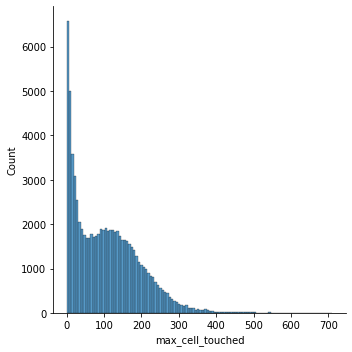

In [30]:
#that is a huge number of dry spells... Expecting they mainly occur in the last months of the rainy season (May/June) but should check thatd
sns.displot(df_hist,x="max_cell_touched")

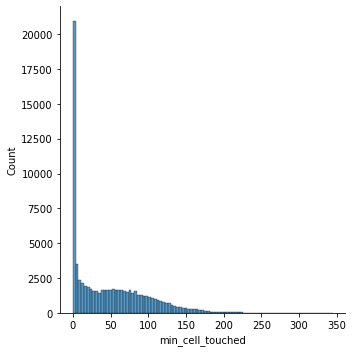

In [31]:
#check how distribution changes when using min cell touched instead of max --> even more sensitive
sns.displot(df_hist,x="min_cell_touched")

In [32]:
print("number of adm2-date combination with min cell touched <=2mm",len(df_hist[df_hist.min_cell_touched<=2]))

number of adm2-date combination with min cell touched <=2mm 19732


In [33]:
print("number of adm2-date combination with max cell touched <=2mm",len(df_hist[df_hist.max_cell_touched<=2]))

number of adm2-date combination with max cell touched <=2mm 2854


In [34]:
print("number of dates with at least one adm2 with max cell touched <=2mm",len(df_hist[df_hist.max_cell_touched<=2].date.unique()))

number of dates with at least one adm2 with max cell touched <=2mm 522


### Observed dryspells and correlation with forecasted dry spells
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with the forecasted CHIRPS-GEFS dry spell

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

For simplicity we are only focusing on forecasting the first 15 days of a dry spell, i.e. the start date of the dry spell corresponds with the start date of the forecast   
This might be too simple, e.g. might want to forecast if a dry spell that already started will persist.

For now this means that if the start_date of the forecast occurs in the dry spell list, we classify it is a true positive

In [35]:
df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","dry_spells_during_rainy_season_list.csv"))
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])

In [36]:
df_ds

,pcode,ADM2_EN,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall
0,MW103,Nkhata Bay,2012-04-19,2012-05-02,14,0.0
1,MW103,Nkhata Bay,2018-04-17,2018-04-30,14,0.0
2,MW104,Rumphi,2012-04-18,2012-05-02,15,0.0
3,MW105,Mzimba,2012-04-19,2012-05-04,16,0.0
4,MW107,Mzuzu City,2011-04-12,2011-04-30,19,0.0
...,...,...,...,...,...,...
78,MW315,Blantyre City,2011-04-10,2011-05-19,40,0.0
79,MW315,Blantyre City,2013-03-21,2013-04-03,14,0.0
80,MW315,Blantyre City,2015-04-01,2015-04-14,14,0.0
81,MW315,Blantyre City,2019-03-21,2019-04-16,27,0.0


In [37]:
#number of historically observed dry spells
#this is waay less than the predicted..
len(df_ds)

83

In [38]:
#dates on which dry spells occured. Apparently never during NDJ (and barely February)
df_ds.dry_spell_first_date.unique()

array(['2012-04-19T00:00:00.000000000', '2018-04-17T00:00:00.000000000',
       '2012-04-18T00:00:00.000000000', '2011-04-12T00:00:00.000000000',
       '2016-04-09T00:00:00.000000000', '2018-04-14T00:00:00.000000000',
       '2020-04-16T00:00:00.000000000', '2011-04-11T00:00:00.000000000',
       '2012-04-12T00:00:00.000000000', '2011-04-10T00:00:00.000000000',
       '2012-04-03T00:00:00.000000000', '2018-04-15T00:00:00.000000000',
       '2014-04-07T00:00:00.000000000', '2015-04-18T00:00:00.000000000',
       '2016-04-05T00:00:00.000000000', '2014-04-10T00:00:00.000000000',
       '2012-04-13T00:00:00.000000000', '2017-04-17T00:00:00.000000000',
       '2018-04-12T00:00:00.000000000', '2013-03-21T00:00:00.000000000',
       '2015-04-01T00:00:00.000000000', '2012-04-02T00:00:00.000000000',
       '2013-03-19T00:00:00.000000000', '2014-03-21T00:00:00.000000000',
       '2018-04-13T00:00:00.000000000', '2020-06-15T00:00:00.000000000',
       '2011-04-09T00:00:00.000000000', '2017-03-07

In [39]:
df_comb=df_ds.merge(df_hist[["ADM2_EN","max_cell_touched","min_cell_touched","dryspell","date","date_forec_end"]],how="right",left_on=["dry_spell_first_date","ADM2_EN"],right_on=["date","ADM2_EN"])

In [40]:
df_comb.head()

,pcode,ADM2_EN,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,max_cell_touched,min_cell_touched,dryspell,date,date_forec_end
0,NaN,Balaka,NaT,NaT,NaN,NaN,0.0,0.0,1,2013-04-18,2013-05-03
1,NaN,Blantyre,NaT,NaT,NaN,NaN,0.0,0.0,1,2013-04-18,2013-05-03
2,NaN,Blantyre City,NaT,NaT,NaN,NaN,0.0,0.0,1,2013-04-18,2013-05-03
3,NaN,Chikwawa,NaT,NaT,NaN,NaN,0.0,0.0,1,2013-04-18,2013-05-03
4,NaN,Chiradzulu,NaT,NaT,NaN,NaN,0.0,0.0,1,2013-04-18,2013-05-03


In [41]:
df_comb.rename(columns={"dryspell":"dryspell_forec"},inplace=True)

In [42]:
#if nan means there was a forecast but no observed dry spell--> set occurence of dry spell to zero
#again, only looking at if any dry spell started on that date, not whether it persisted
df_comb["dryspell_obs"]=np.where(df_comb.dry_spell_first_date.notna(),1,0)

In [43]:
# Aaah somehow 4 dry spells went missing when merging on the forecast list
#TODO: check how (might have to do with missing data in 2020..)
len(df_comb[df_comb.dryspell_obs==1])

79

In [44]:
#observed dry spell list only contains data from 2010 onwards
#TODO:set this based on the rainy season list instead of by hand
df_comb_obs=df_comb[df_comb.date>="2010-01-01"]

[[72626  2847]
 [   73     6]]


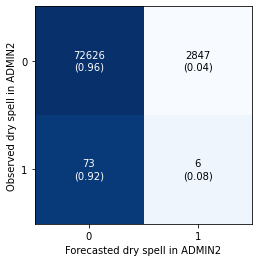

In [45]:
#compute the contigency table
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb_obs["dryspell_obs"]
y_predicted = df_comb_obs["dryspell_forec"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

#### First attempt to understand the differences forecasted and observed

In [46]:
#sum of dryspells per adm2 in 2011, doesn't mean they had to occur on the same dates
df_comb_obs[(df_comb_obs.date.dt.year==2011)].groupby("ADM2_EN").sum()[["dryspell_forec","dryspell_obs"]]#.date.sort_values().unique()

,dryspell_forec,dryspell_obs
ADM2_EN,,
Balaka,6,1
Blantyre,3,1
Blantyre City,4,1
Chikwawa,1,1
Chiradzulu,3,1
Chitipa,0,0
Dedza,2,0
Dowa,13,1
Karonga,0,0


Text(0.5, 1.0, 'Forecasted rainfall Balaka 2011')

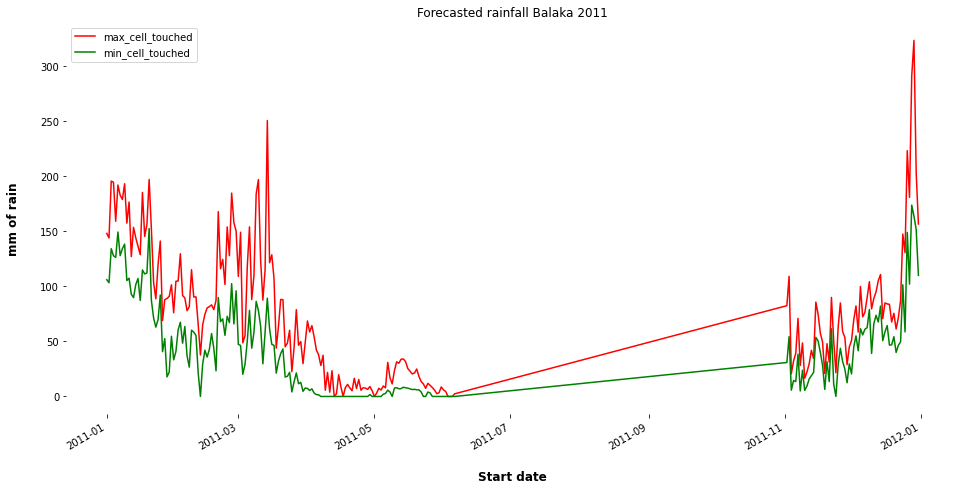

In [47]:
#inspect difference min and max cell touched
fig,ax=plt.subplots()
df_comb_obs[(df_comb_obs.date.dt.year==2011)&(df_comb_obs.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="max_cell_touched" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_comb_obs[(df_comb_obs.date.dt.year==2011)&(df_comb_obs.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="min_cell_touched" ,figsize=(16, 8), color='green',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("mm of rain", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Forecasted rainfall Balaka 2011")

Text(0.5, 1.0, 'Observed and forecasted dryspells')

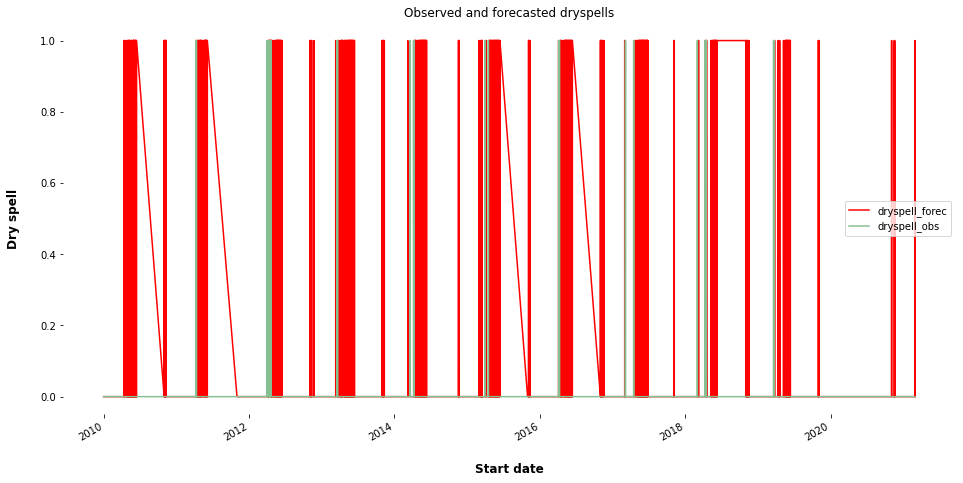

In [48]:
#try to plot observed and forecasted dry spells
#have to find a better way to compare
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_comb_obs.sort_values(by="date").plot(x="date",y="dryspell_forec" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_comb_obs.sort_values(by="date").plot(x="date",y="dryspell_obs" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Dry spell", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Observed and forecasted dryspells")